In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

In [2]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [4]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [500]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [5]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [6]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"model_velocities_bse/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

9.250712394714355 s


In [7]:
def plot_kde(PLOT_RANGE, d=2):
 
    for i in PLOT_RANGE:
        kde_NS_3D = gaussian_kde( NS_KICKS_3D[i] )
        kde_NS_2D = gaussian_kde( NS_KICKS_2D[i] )
        NS_dist_space = linspace( min(NS_KICKS_3D[i]), max(NS_KICKS_3D[i]), 100 )
        
        if d==2:
            plt.plot( NS_dist_space, kde_NS_2D(NS_dist_space), label=f'2D Projected Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');
        else:
            plt.plot( NS_dist_space, kde_NS_3D(NS_dist_space), label=f'3D Model Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [km/s ^-1]')

    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

    # plt.ylim(0, 5e-3)
    plt.xlim(0, 1200)

    plt.legend(fontsize=17)

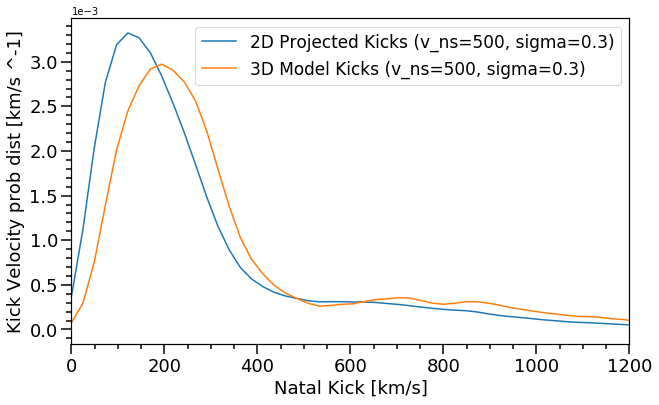

In [8]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plot_kde(np.intersect1d(kick_models["NS_500_RANGE"], kick_models["SIGMA_0.3_RANGE"]), d=2)
plot_kde(np.intersect1d(kick_models["NS_500_RANGE"], kick_models["SIGMA_0.3_RANGE"]), d=3)
plt.show()

# Read Likelihood Data

In [9]:
p_models = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods_bse/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models = p_models/np.sum(p_models)

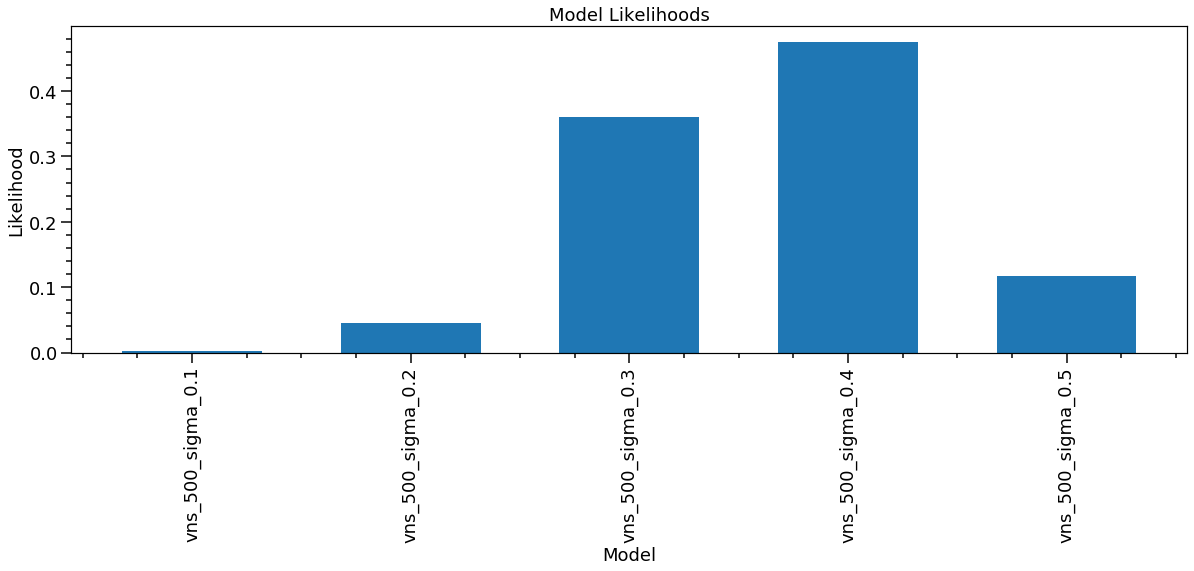

In [10]:
f, ax= plt.subplots(1, 1,  figsize=(20,6)) 

x_range = np.linspace(0, len(p_models), len(p_models))
plt.bar(x_range, p_models, tick_label=columns)

layoutAxes(ax=ax, nameX='Model',\
           nameY='Likelihood')
plt.xticks(rotation=90)
# plt.semilogy()

plt.title("Model Likelihoods", fontsize=18)

plt.show()

## 2D Plot

In [13]:
p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
max_num = 2 # number of max likelihoods to label

# Some code to generate labels for only the top n models
M = sorted(zip(p_models), reverse=True)[max_num - 1][0]
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels = label_f(p_models_2d)

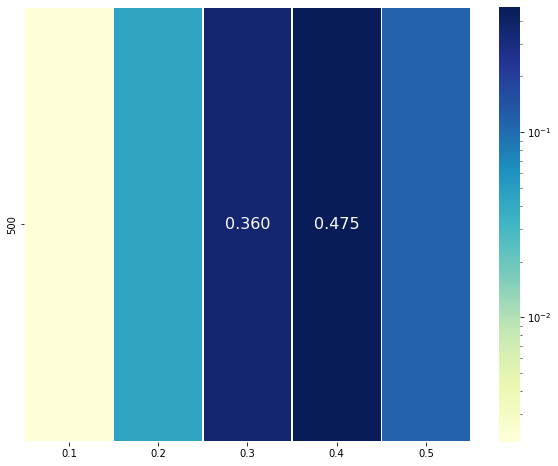

In [14]:
f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

ax = sns.heatmap(p_models_2d, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), xticklabels=sigmas, yticklabels=ns_kicks, \
                annot=labels, annot_kws={'fontsize':16}, fmt='')
plt.show()

In [15]:
# Identify the 3 most likely models
M = sorted(zip(p_models), reverse=True)[:3]
MAX_INDICES = np.where(p_models==M)[1]

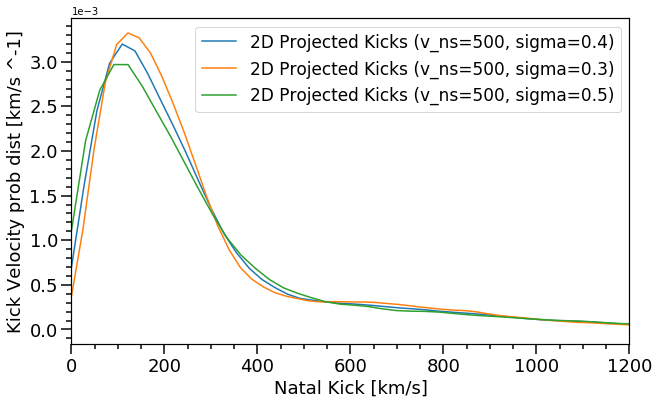

In [16]:
# The three most likely models
f, ax= plt.subplots(1, 1,  figsize=(10,6))
plot_kde(MAX_INDICES, d=2)
plt.show()

# Load in the remaining (Posterior) Data

In [17]:
# Takes about 30 s
start = time.time()

vt_all = []

for file in glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'):
    vt_all.append(np.loadtxt(file, unpack=True, usecols=5))

end = time.time()
print(end - start, "s")

27.314129114151 s


In [18]:
PLOT_DATA = [vt_all, NS_KICKS_2D, NS_KICK_MULT, SIGMAS] # Needed to make all the cdf functions work

# CDF Plots

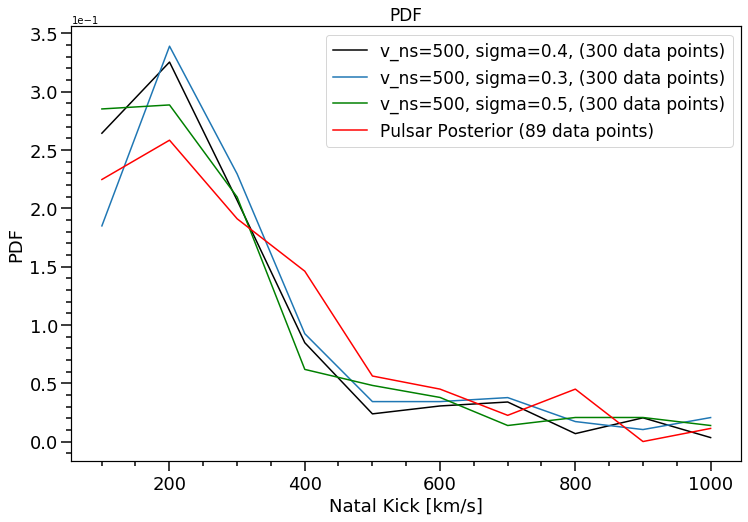

In [20]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[0], color='k')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[1], color='C0')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[2], color='g')

lpf.plot_posterior_pdf(*PLOT_DATA, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='PDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"PDF", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
# plt.semilogx()
plt.show()


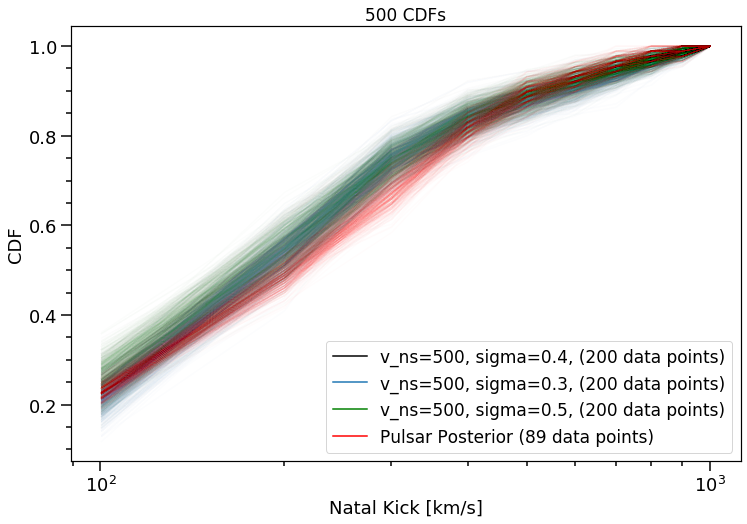

Plot completed in 25.683827 s


In [21]:
n_cdf = 500
n_draws = 200
alpha = 5/n_cdf

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

start = time.time()

lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_draws=n_draws, color='k', alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_draws=n_draws, color='C0', alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_draws=n_draws, color='g', alpha=alpha)

# Posterior CDF always contains len(vt_all) data points in current implementation. 
# See 'draw_posterior_cdf' function for alternate implementation with n_draws data points
lpf.plot_posterior_cdf(*PLOT_DATA, n_cdf, n_draws=n_draws, color='r', alpha=alpha)



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"{n_cdf} CDFs", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
plt.semilogx()
plt.show()

end = time.time()
print(f"Plot completed in {end - start:2f} s")

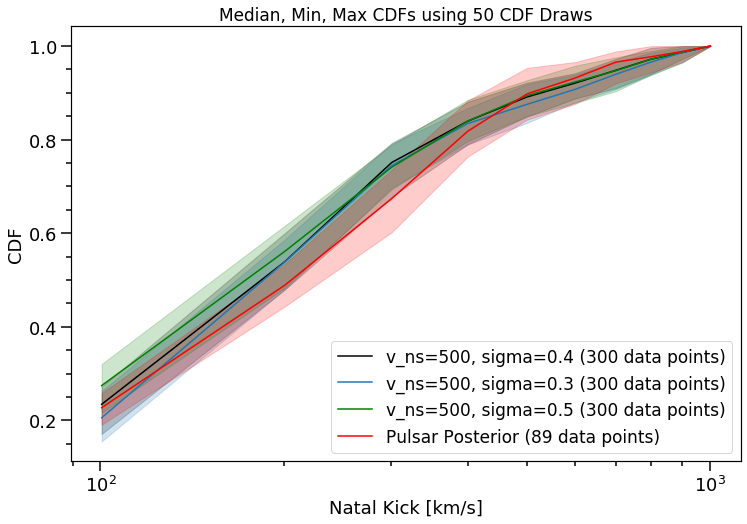

Plot completed in 2.411882 s


In [22]:
n_cdf = 50
n_bins = 10
n_draws = 300

start = time.time()


f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws, color='k')
lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws,color='C0')
lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws,color='g')


lpf.plot_avg_posterior_cdf(*PLOT_DATA, n_cdf, n_bins=n_bins, n_draws=n_draws,color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')


plt.title(f"Median, Min, Max CDFs using {n_cdf} CDF Draws", fontsize=17)

plt.legend(fontsize=17)
    
    
plt.semilogx()
plt.show()


end = time.time()
print(f"Plot completed in {end - start:2f} s")

## See effect of changing n_cdf, n_draws

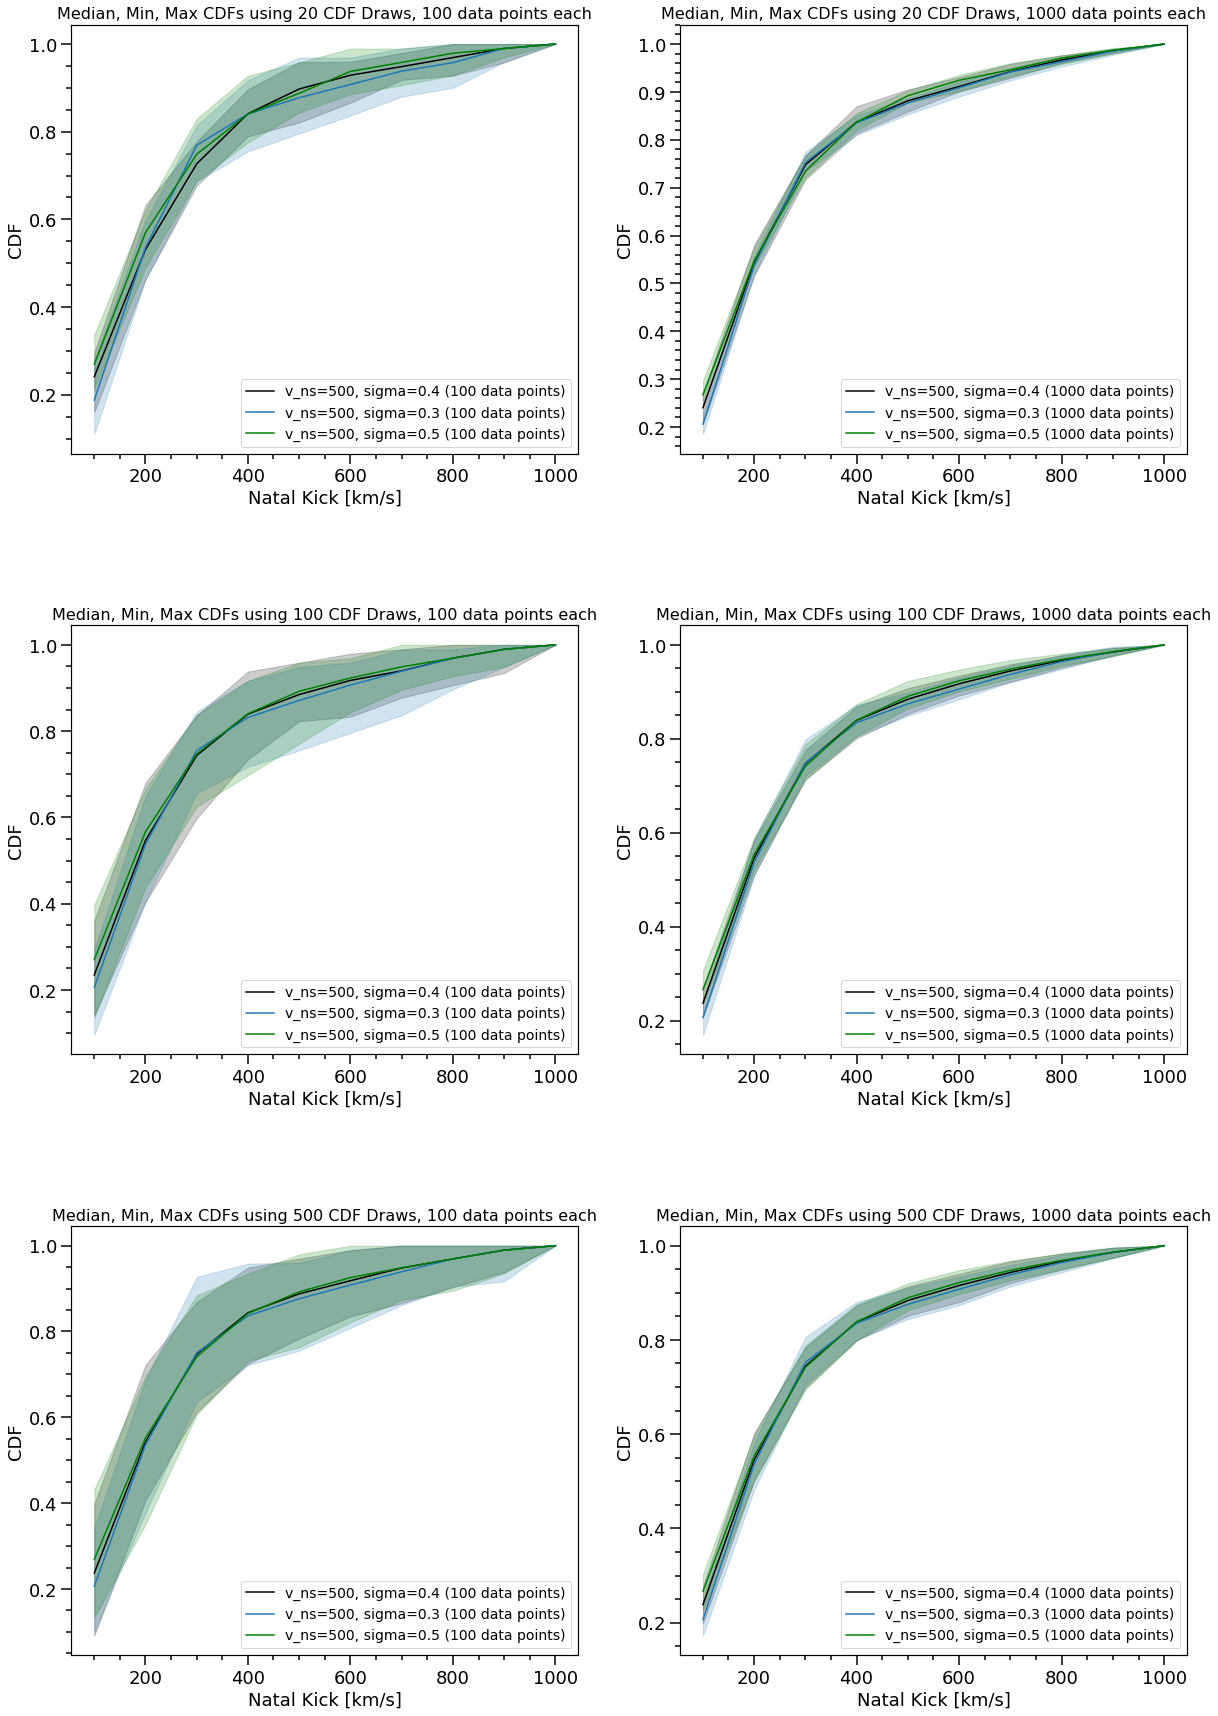

Plot completed in 41.167592 s


In [23]:
n_cdfs = [20, 100, 500]
n_bins = 10
n_drawss = [100, 1000]

start = time.time()

plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.4)
n=1

for n_cdf in n_cdfs:
    for n_draws in n_drawss:
        ax = plt.subplot(3, 2, n)
        n+=1
        lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws, color='k')
        lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws, color='C0')
        lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws, color='g')

        layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
                   nameY='CDF')

        plt.title(f"Median, Min, Max CDFs using {n_cdf} CDF Draws, {n_draws} data points each", fontsize=16)
        plt.legend(fontsize=14)

plt.show()


end = time.time()
print(f"Plot completed in {end - start:2f} s")

As expected, we see the following two trends:
1. Increasing the number of CDFs drawn (n_cdfs) enables us to capture the highest and lowest range of CDF. Thus, the spread increases until it asymptotes to the true spread.

2. Increasing the number of data draws per CDF (n_draws) reduces the variation between CDFs, resulting in a smaller spread. At the limit of n_draws = all data points in simulation, the variation will be zero.

Visually, the Green curve (vns=550, sigma=0.4) has the closest CDF and PDF to the posterior, even though it is the 3rd most likely model from Bayesian Analysis. Let's confirm this using a KS test...

# K-S Test

In [24]:
# Get all the cdfs needed for KS test
n_cdf = 100
n_bins = 20
n_draws = 100
bins, cdf_0, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws)
bins, cdf_1, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws)
bins, cdf_2, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws)

bins_posterior, cdf_posterior, cdf_min, cdf_max, draws = lpf.get_avg_posterior_cdf(*PLOT_DATA, n_cdf, n_bins=n_bins)

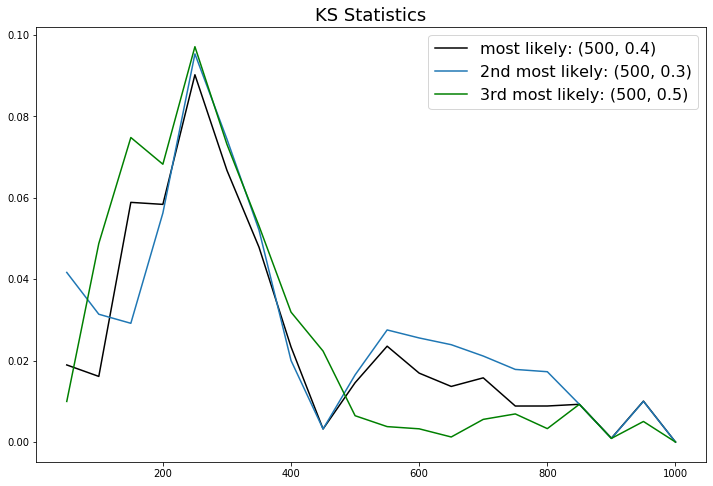

In [25]:
# Plot the KS-statistics

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
plt.plot(bins, np.abs(cdf_0 - cdf_posterior), color='k', label=f'most likely: ({NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]})')
plt.plot(bins, np.abs(cdf_1 - cdf_posterior), color='C0', label=f'2nd most likely: ({NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]})')
plt.plot(bins, np.abs(cdf_2 - cdf_posterior), color='g', label=f'3rd most likely: ({NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]})')
plt.title("KS Statistics", fontsize=18)

plt.legend(fontsize=16)
plt.show()

In [26]:
print(f"KS Statistic for {NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]} =", np.max(np.abs(cdf_0 - cdf_posterior)))
print(f"KS Statistic for {NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]} =", np.max(np.abs(cdf_1 - cdf_posterior)))
print(f"KS Statistic for {NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]} =", np.max(np.abs(cdf_2 - cdf_posterior)))

KS Statistic for 500, 0.4 = 0.09023159825728044
KS Statistic for 500, 0.3 = 0.09535117185991726
KS Statistic for 500, 0.5 = 0.09712422150530742


## Scipy implementation

In [27]:
vt_all_flat = [item for sublist in vt_all for item in sublist] # in case I should use ALL the posteriors

In [28]:
from scipy.stats import *

In [29]:
n_draws = 1000

In [30]:
vt_draw = np.zeros(len(vt_all))        
for i in range(len(vt_draw)):
    vt_draw[i] = vt_all[i][np.random.randint(len(vt_all[i]))]

In [31]:
for i in [0,1,2]:
    model = NS_KICKS_2D[MAX_INDICES[i]]
    model_draws = np.zeros(n_draws)
    bins = lpf.set_bins_from_posterior(vt_draw, n_bins=n_bins) 
    for j in range(len(model_draws)):
        model_draws[j] = model[np.random.randint(len(model))]
    
#     ks_stat, p_value = ks_2samp(vt_draw, model_draws)
    ks_stat, p_value = ks_2samp(vt_all_flat, model_draws)
    print(f"KS Test for {NS_KICK_MULT[MAX_INDICES[i]]}, {SIGMAS[MAX_INDICES[i]]}: ks_stat = {ks_stat}, p_value = {p_value}")

KS Test for 500, 0.4: ks_stat = 0.080340647965504, p_value = 4.9576354923687255e-06
KS Test for 500, 0.3: ks_stat = 0.06642278967950477, p_value = 0.0002946288175553417
KS Test for 500, 0.5: ks_stat = 0.06300755083972664, p_value = 0.0007131443959928017


I'm not convinced I'm correctly using the KS test from scipy, but the general result remains the same: the (550, 0.4) model is the closest match to the posterior.

(Could this be an artifact of the way I sample CDFs? Although this shouldn't be an issue for the scipy implementation because that takes in ALL the data and posteriors)